In [9]:
#all imports
import numpy as np
import csv
import math
import matplotlib.pyplot as plt

In [10]:
#Read in u.data and create A matrix
num_users=943
num_items=1682
A=np.zeros((num_users,num_items))
with open('u.data') as file:
    for line in csv.reader(file,delimiter="\t"):
        A[int(line[0])-1,int(line[1])-1]=line[2]

Plotting the histograms

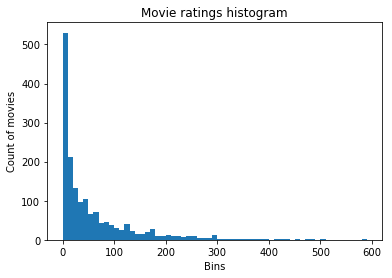

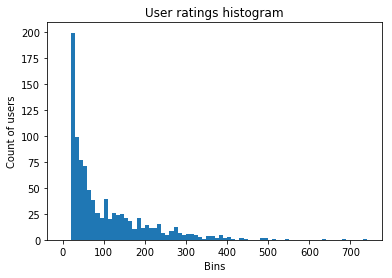

In [11]:
#movie_ratings = number of ratings for a movie
movie_ratings=(A!=0).sum(axis=0)
bins1=np.arange(0,int(np.max(movie_ratings))+10,10.0)
#In int(np.max(movie_ratings))+10 #+10 is to include the last value as well
plt.hist(movie_ratings,bins1)
plt.title('Movie ratings histogram')
plt.xlabel('Bins')
plt.ylabel('Count of movies')
plt.show()
#user_ratings = number of ratings for a user
user_ratings=(A!=0).sum(axis=1)
bins2=np.arange(0,int(np.max(user_ratings))+10,10.0)
#In int(np.max(user_ratings))+10 #+10 is to include the last value as well
plt.hist(user_ratings,bins2)
plt.title('User ratings histogram')
plt.xlabel('Bins')
plt.ylabel('Count of users')
plt.show()

Calculating Abase from ua.base and Atest from ua.test

In [12]:
Abase=np.zeros((num_users,num_items))
with open('ua.base') as file1:
    for line in csv.reader(file1,delimiter="\t"):
        Abase[int(line[0])-1,int(line[1])-1]=line[2]
Atest=np.zeros((num_users,num_items))
with open('ua.test') as file2:
    for line in csv.reader(file2,delimiter="\t"):
        Atest[int(line[0])-1,int(line[1])-1]=line[2]

Computing mu, bu, bi

In [13]:
#mu=mean over all the non-zero entries
mu=np.sum(Abase)/np.count_nonzero(Abase)
print ("Mu = ",mu) #REMOVE
#calculating bi for each item
lambda2=25
bi=np.zeros(num_items)
for i in range(0,num_items):
    t=0
    count=0
    for u in range(0,num_users):
        if Abase[u,i]!=0:
            t=t+Abase[u,i]-mu
            count+=1
    bi[i]=t/(lambda2+count)

#calculating bu for each user
lambda3=10
bu=np.zeros(num_users)
for u in range(0,num_users):
    Ru=np.copy(Abase[u])
    temp=np.copy(Ru)
    for i in range(0,Ru.shape[0]):
        if Ru[i]!=0:
            temp[i]=Ru[i]-mu-bi[i]
    bu[u]=np.sum(temp)/(lambda3+np.count_nonzero(Ru))


Mu =  3.52382687424


In [15]:
#calculate b_ui over test set
bui=np.zeros((num_users,num_items))
for u in range(0,num_users):
    for i in range(0,num_items):
        if Atest[u,i]!=0: #REMOVE IF CALCULATING ALL ENTRIES!!!
            bui[u,i]=mu+bu[u]+bi[i]
#calculating the RMSE
RMSE=np.zeros(Atest.shape)
for u in range(0,num_users):
    for i in range(0,num_items):
        if Atest[u,i]!=0:
            RMSE[u,i]=pow((Atest[u,i]-bui[u,i]),2)
RMSE_val=math.sqrt(np.sum(RMSE)/np.count_nonzero(Atest))
print ("Baseline RMSE=",RMSE_val)

Baseline RMSE= 0.9664817838879253


Part c for baseline: Plotting the RMSE per user

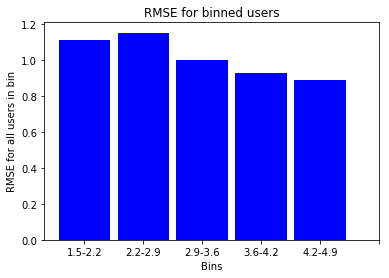

In [19]:
#calculate the average rating per user, only considering non-zero ones
avg_per_user=np.zeros(num_users)
for u in range(0,num_users):
    count=0
    t=0
    for i in range(0,num_items):
        if Abase[u,i]!=0:
            t+=Abase[u,i]
            count+=1
    avg_per_user[u]=t/count
bins=np.linspace(np.min(avg_per_user),np.max(avg_per_user),6) #6 numbers, 5 bins


RMSE_binned=np.zeros(5)
for k in range(0,5):
    bin_start=bins[k]
    bin_end=bins[k+1]
    
    RMSE=0
    count=0
    for u in range(0,num_users):
        if avg_per_user[u]>=bin_start and avg_per_user[u]<bin_end:
            for i in range(0,num_items):
                if Atest[u,i]!=0:
                    RMSE+=pow((Atest[u,i]-bui[u,i]),2)
                    count+=1
    RMSE_binned[k]=math.sqrt(RMSE/count)
    RMSE=0
    count=0

#plot the RSME per user
plt.bar(bins[0:5],RMSE_binned,width=0.6,color='blue')
#rounding the bins for labelling the x axis and making the bins for ticks
round_bins=[str(round(bins[i],1))+'-'+str(round(bins[i+1],1)) for i in range(0,5)]
plt.xticks(bins,round_bins)
plt.title('RMSE for binned users')
plt.xlabel('Bins')
plt.ylabel('RMSE for all users in bin')
plt.show()


NOTE- Rounded off the bins to one decimal to fit properly below each bar.

Calculate the similarity matrix

In [ ]:
sim=np.zeros((num_items,num_items))
for i in range(0,num_items):
    #if i%100==0:    #JUST FOR CHECKING
    #    print (i)
    Ui1=Abase[:,i]
    for j in range(i,num_items):
        if i!=j:
            Ui2=Abase[:,j]
            s1=0
            s2=0
            s3=0
            for u in range(0,num_users):
                if Ui1[u]!=0 and Ui2[u]!=0:
                    #this is the intersection
                    s1+=(Abase[u,i]-avg_per_user[u])*(Abase[u,j]-avg_per_user[u])
                    s2+=pow((Abase[u,i]-avg_per_user[u]),2)
                    s3+=pow((Abase[u,j]-avg_per_user[u]),2)
            #if denominator is 0, setting s(i,j)=1 as mentioned on piazza, is a reasonable approach
            if s2==0 or s3==0:
                sim[i,j]=1
            else:
                sim[i,j]=s1/math.sqrt(s2*s3)
        else:
            sim[i,j]=1 #diagonal elements
    #we filled only the bottom triangle, the matrix is symmetric, so we can copy it into the top triangle
    for i in range(0,num_items):
        for j in range(0,i):
            sim[i,j]=sim[j,i]


Find the k nearest neighbours

Predict values for k=1,2,3,5,10

For K =  1 , RMSE =  1.416611044174512
Binned RMSE = [ 1.36014705  1.57762128  1.5042175   1.36441853  1.11205515]


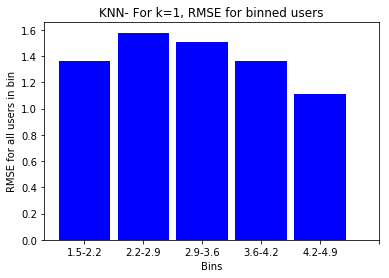

For K =  2 , RMSE =  1.2164776947286806
Binned RMSE = [ 1.31321716  1.43546239  1.2969953   1.15200581  0.98581032]


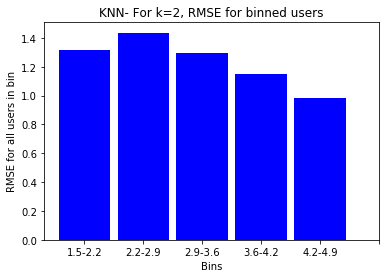

For K =  3 , RMSE =  1.1458335659949233
Binned RMSE = [ 1.32348427  1.3561176   1.20764232  1.09419594  0.94116268]


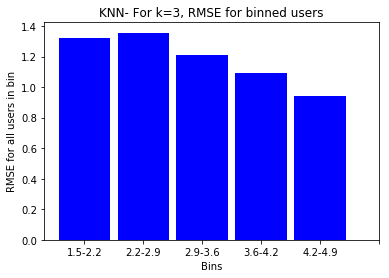

For K =  5 , RMSE =  1.097782866324411
Binned RMSE = [ 1.35668121  1.33512871  1.14098473  1.05195867  0.94002878]


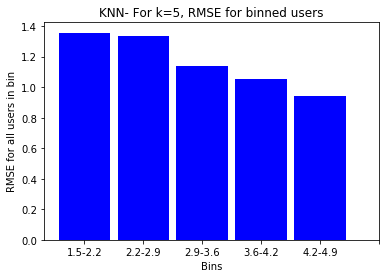

For K =  10 , RMSE =  1.3387517094251729
Binned RMSE = [ 1.55284424  1.86654004  1.32444519  1.23843969  1.64272867]


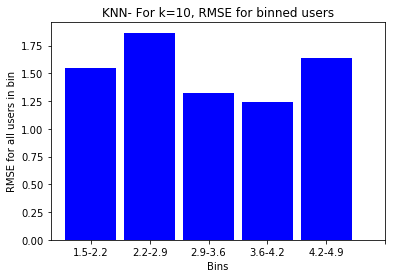

In [22]:
avg_over_all=Abase.mean()
k_list=[1,2,3,5,10]
for k_val in k_list:
    pred=np.zeros(Atest.shape)
    for u in range(0,num_users):
        for i in range(0,num_items):
            if Atest[u,i]!=0:
                #predict for only these values
                user_sim=np.zeros(num_items)
                user_sim.fill('-inf')
                #user_sim[j] stores the similarity of item i with rated item j
                count=0
                for j in range(0,num_items):
                    if Abase[u,j]!=0: #user has already rated this item
                        user_sim[j]=np.copy(sim[i,j])
                        count+=1
                if count==0: #no history for this u,i pair
                    pred[u,i]=avg_over_all
                else:
                    #find the k top values, their indices
                    if k_val==1: #find max, it's faster
                        index=np.argmax(user_sim)
                        pred[u,i]=sim[i,index]*Abase[u,index]/abs(sim[i,index])
                    else:
                        if count<k_val:
                            topk_indices = user_sim.argsort()[-count:][::-1]
                        else:
                            topk_indices = user_sim.argsort()[-k_val:][::-1]
                        t1=0
                        t2=0
                        for n in topk_indices:
                            t1+=sim[i,n]*Abase[u,n]
                            t2+=abs(sim[i,n]) #CHECK! is it mod??
                        pred[u,i]=t1/t2

    RMSE=np.zeros(Atest.shape)
    for u in range(0,num_users):
        for i in range(0,num_items):
            if Atest[u,i]!=0:
                RMSE[u,i]=pow((Atest[u,i]-pred[u,i]),2)
    RMSE_val=math.sqrt(np.sum(RMSE)/np.count_nonzero(Atest))
    print ("For K = ",k_val,", RMSE = ",RMSE_val)

    #plotting the binned RMSEs

    RMSE_binned = np.zeros(5)
    for g in range(0, 5):
        bin_start = bins[g]
        bin_end = bins[g + 1]
        # CHECK- to make sure the max is included??
        RMSE_int = 0
        count = 0
        for u in range(0, num_users):
            if avg_per_user[u] >= bin_start and avg_per_user[u] < bin_end:
                for i in range(0, num_items):
                    if Atest[u, i] != 0:
                        RMSE_int += pow((Atest[u, i] - pred[u, i]), 2)
                        count += 1
        RMSE_binned[g] = math.sqrt(RMSE_int / count)
    # plot the RSME per user
    print ("Binned RMSE =",RMSE_binned)
    plt.bar(bins[0:5], RMSE_binned, width=0.6, color='blue')
    # rounding the bins for labelling the x axis and making the bins for ticks
    round_bins = [str(round(bins[i], 1)) + '-' + str(round(bins[i + 1], 1)) for i in range(0, 5)]
    plt.xticks(bins, round_bins)
    plt.title('KNN- For k='+str(k_val)+', RMSE for binned users')
    plt.xlabel('Bins')
    plt.ylabel('RMSE for all users in bin')
    plt.show()